In [1]:
# Cell 1 - Tell python where to find the modules to import from

import sys
from pathlib import Path

#Path.cwd().parent depends on where you run this code from
#Path(__file__).resolve().parents[1] depends on where this file is located on disk
#
#project_root = .../1099-reconciliation-pipeline if notebook runs from the repo root or from notebooks/
cwd = Path.cwd()
project_root = cwd if (cwd / "src").exists() else cwd.parent # running from notebooks/  folder (cwd = current working directory) - .parent gets us to the folder above
sys.path.append(str(project_root)) #sys.path is a list of folders where python looks for modules
                                    # we add the project root to that list with .append

print("Project root: ", project_root)


Project root:  /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline


'--------------------------------  Engine A: Load & Run Analysis  --------------------------------'

In [2]:
# Cell 2 - Imports, Load & Clean inputs (real paths)

from src import load_data
from src.clean_matrix import clean_matrix
from src.clean_relius import clean_relius
from src.match_transactions import reconcile_relius_matrix
from src.match_planid_visualization import (
    build_match_kpi_summary,
    plot_match_kpi_summary,
    build_unmatched_summary,
    plot_unmatched_summary,
    build_date_lag_distribution,
    plot_date_lag_distribution,
    build_correction_reason_summary,
    plot_correction_reason_summary,
)
from src.config import RAW_DATA_DIR, REPORTS_FIGURES_DIR, USE_SAMPLE_DATA_DEFAULT

if USE_SAMPLE_DATA_DEFAULT:
    matrix_path = None
    relius_path = None
else:
    matrix_path = RAW_DATA_DIR / "real_all_matrix_2025.xlsx"
    relius_path = RAW_DATA_DIR / "real_inherited_relius_2025.xlsx"

# Load and clean Matrix raw data
matrix_raw = load_data.load_matrix_excel(path=matrix_path)
matrix_clean = clean_matrix(matrix_raw)

# Load and clean Relius raw data
relius_raw = load_data.load_relius_excel(path=relius_path)
relius_clean = clean_relius(relius_raw)

# Run Engine A reconciliation
match_results = reconcile_relius_matrix(relius_clean, matrix_clean)

print("Engine A rows:", match_results.shape[0])
match_results.head(5)


/var/folders/_5/q9dxw26d4rl_63x79z_n9kkm0000gn/T/ipykernel_48311/381015974.py:28: UserWarning: Matrix SSN normalization produced 11 invalid values.
  matrix_clean = clean_matrix(matrix_raw)
/Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/src/normalizers.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(series, errors=errors, format=format, dayfirst=dayfirst).dt.date


Engine A rows: 662


,plan_id,ssn,first_name,last_name,state_relius,gross_amt,exported_date,tax_year,dist_code_1,dist_name,...,match_status,expected_tax_code_1,expected_tax_code_2,code_matches_expected,needs_correction,suggested_tax_code_1,suggested_tax_code_2,correction_reason,action,new_tax_code
0,300004MBD,150406376,NaN,NaN,NaN,151452.18,NaT,<NA>,<NA>,NaN,...,unmatched_matrix,<NA>,<NA>,False,False,<NA>,<NA>,<NA>,<NA>,<NA>
1,300004MBD,150406376,Robert,Wilkins,DE,151522.18,2025-10-15,0,G,Rollover,...,unmatched_relius,<NA>,<NA>,True,False,<NA>,<NA>,<NA>,<NA>,<NA>
2,300004MBD,159364560,Maria,Cantalupo,PA,10872.69,2025-10-02,0,4,RMD ACH,...,match_no_action,4,<NA>,True,False,<NA>,<NA>,<NA>,<NA>,<NA>
3,300004MBD,186545616,Maureen,King,PA,25000.00,2025-09-22,0,4,Partial Liquidation Net ACH,...,match_no_action,4,<NA>,True,False,<NA>,<NA>,<NA>,<NA>,<NA>
4,300004MBD,188368532,NaN,NaN,NaN,1699.02,NaT,<NA>,<NA>,NaN,...,unmatched_matrix,<NA>,<NA>,False,False,<NA>,<NA>,<NA>,<NA>,<NA>


'--------------------------------  Metrics & Plots  --------------------------------'

In [3]:
# Cell 3 - Match status KPI summary

kpi_summary = build_match_kpi_summary(match_results)
kpi_summary


,status_group,count,percent
0,no_action,40,0.060423
1,needs_correction,114,0.172205
2,needs_review,0,0.000000
3,date_out_of_range,457,0.690332
4,unmatched_relius,28,0.042296
5,unmatched_matrix,23,0.034743


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_a_match_status_kpi.png


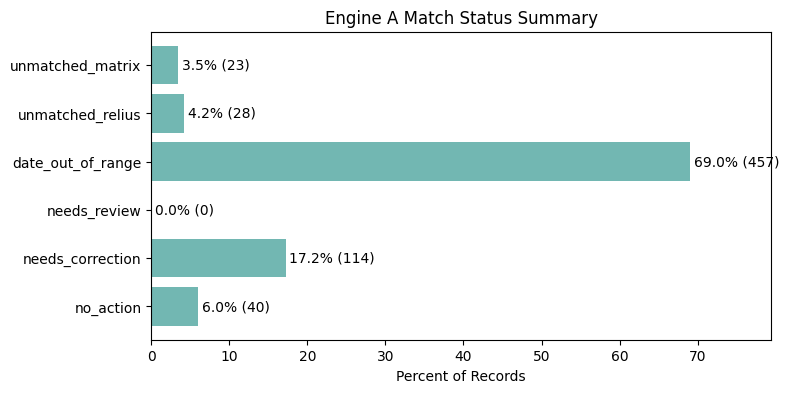

In [4]:
# Cell 4 - Plot match status KPI summary and save

fig1, _ = plot_match_kpi_summary(kpi_summary)
output_path = REPORTS_FIGURES_DIR / "engine_a_match_status_kpi.png"
fig1.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [5]:
# Cell 5 - Unmatched summary

unmatched_summary = build_unmatched_summary(match_results)
unmatched_summary


,unmatched_group,count,percent
0,unmatched_relius,28,0.042296
1,unmatched_matrix,23,0.034743


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_a_unmatched_summary.png


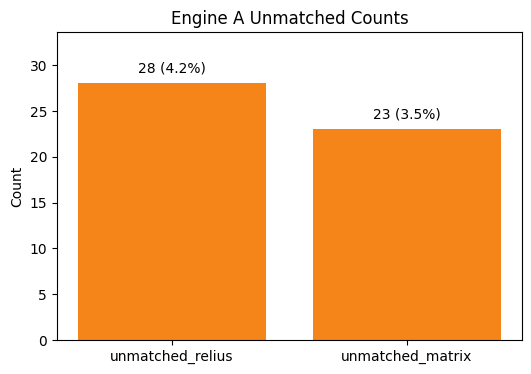

In [6]:
# Cell 6 - Plot unmatched summary and save

fig2, _ = plot_unmatched_summary(unmatched_summary)
output_path = REPORTS_FIGURES_DIR / "engine_a_unmatched_summary.png"
fig2.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [7]:
# Cell 7 - Date lag distribution

date_lag_metrics = build_date_lag_distribution(match_results)
date_lag_metrics.head(10)


,date_lag_days,count
0,-146,7
1,-145,3
2,-142,3
3,-140,2
4,-125,11
5,-124,4
6,-116,7
7,-113,3
8,-112,3
9,-110,1


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_a_date_lag_distribution.png


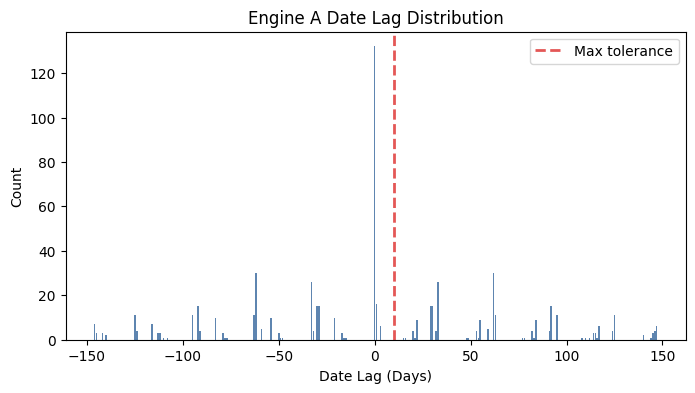

In [8]:
# Cell 8 - Plot date lag distribution and save

fig3, _ = plot_date_lag_distribution(date_lag_metrics)
output_path = REPORTS_FIGURES_DIR / "engine_a_date_lag_distribution.png"
fig3.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [9]:
# Cell 9 - Correction reason summary

reason_summary = build_correction_reason_summary(match_results)
reason_summary


,correction_reason,count,percent
0,inherited_cash_expected_4,114,1.0


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_a_correction_reason_summary.png


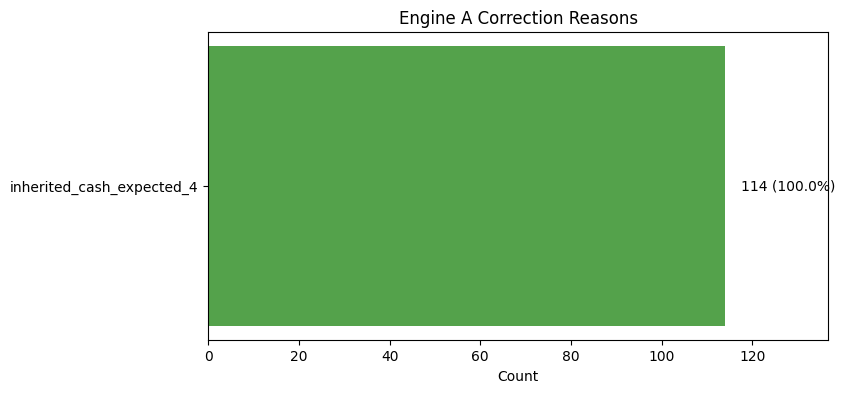

In [10]:
# Cell 10 - Plot correction reason summary and save

fig4, _ = plot_correction_reason_summary(reason_summary)
output_path = REPORTS_FIGURES_DIR / "engine_a_correction_reason_summary.png"
fig4.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)
